#MODELAGEM DE DISPERSÃO

Implementação do Modelo de Dispersão Gaussiano.

Autores: Sérgio Strack e Sabrina de Melo

In [42]:
# Criando uma função do modelo gaussiano
import numpy as np
def modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H):
    termo1 = qs/(2*np.pi*sigmaY*sigmaZ*u)
    termo2 = np.exp((-y**2)/(2*sigmaY**2))
    termo3 = np.exp((-(z-H)**2)/(2*sigmaZ**2)) + np.exp((-(z+H)**2)/(2*sigmaZ**2))
    conc = termo1*termo2*termo3
    conc = conc*10**6
    return conc

In [43]:
# Criando função da estimativa da dispersão lateral e vertical da pluma
def sigmaXY(x,classe,urbOrRural):
    if urbOrRural=='urbano':
        if (classe=='A') or (classe=='B'):
            sigmaY = 0.32*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.24*x*(1+0.001*x)**(0.5)
        else:
            print('Classe de estabilidade errada')
    if urbOrRural=='rural':
        if (classe=='A') :
            sigmaY = 0.22*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.20*x
        else:
            print('Classe de estabilidade errada. Fique ligado')
    return sigmaY,sigmaZ

In [44]:
# Função para estimar o deltaH com base na equação de Davidson-Bryant
def deltaHdavidsonBryant(d,vs,u,Ts,Tamb):
    deltaH = (d*(vs/u)**(1.4))*(1+(Ts-Tamb)/Ts)
    return deltaH

In [45]:
# Utilizando a função do modelo gaussiano
qs = 100 # g/s
sigmaY = 10 # m
sigmaZ = 15 # m
u = 10 # m/s
y = 0 # estimando na direção do vento
z = 1.5 # altura do nariz
H = 50 # m

# Chamando a função do modelo gaussiano
conc = modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H)

print("A concentração estimada é = " +str(conc) + ' [$\mu$]g/m³')

A concentração estimada é = 86.2052564132534 [$\mu$]g/m³


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\4181632413.py:13: SyntaxWarning: invalid escape sequence '\m'
  print("A concentração estimada é = " +str(conc) + ' [$\mu$]g/m³')


deltaH = 2.700592857381857
A pluma subiu


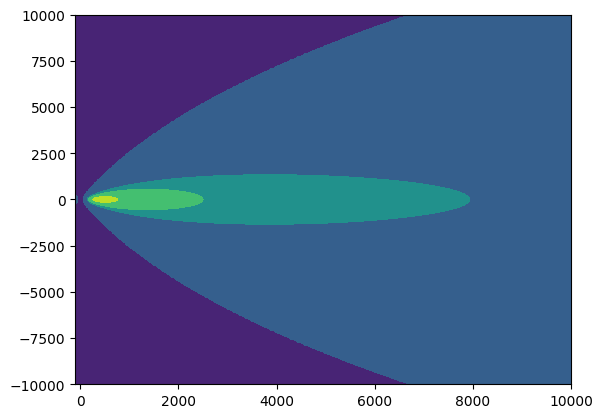

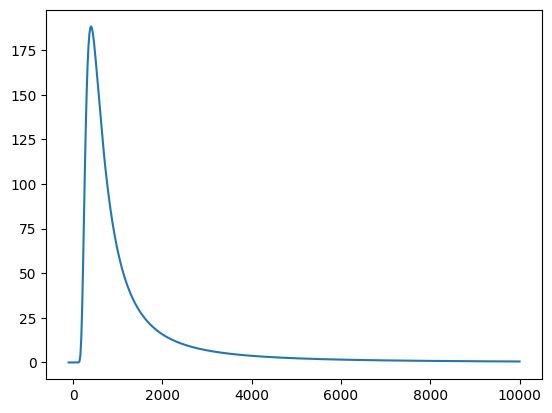

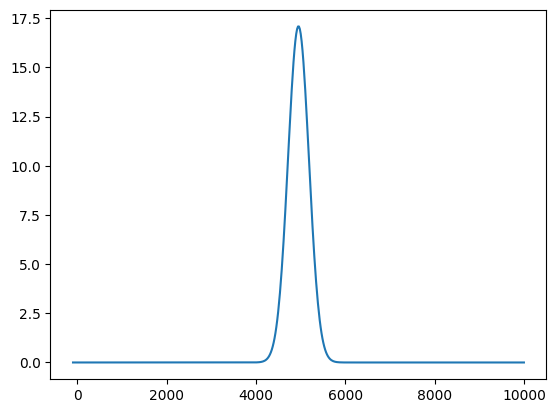

In [46]:
# Criando domínio de modelagem 
x = np.linspace(-100,10000,500)
#print(x)
y = np.linspace(-10000,10000,500)

# Criando matrizes de x e y
xx,yy = np.meshgrid(x,y)
#print(xx.shape)


# Adotando inputs
classe = 'A'
urbOrRural = 'urbano' 
hg = 150 # m altura geométrica da chaminé
qs = 100 # g/s
sigmaY = 10 # m
sigmaZ = 15 # m
u = 5 # m/s
y = 0 # estimando na direção do vento
z = 1.5 # altura do nariz
d = 1 # em metros
vs = 10 # em m/s
Ts = 300 # em Kelvin
Tamb = 293 # em Kelvin

# Estimando o coeficiente de dispersão lateral e vertical
sigmaY,sigmaZ = sigmaXY(xx,classe,urbOrRural)
#print(sigmaY)

if vs>1.5*u:
    # Estimando a sobrelevação da pluma (deltaH)
    deltaH = deltaHdavidsonBryant(d,vs,u,Ts,Tamb)
    print('deltaH = '+str(deltaH))
    hef = hg+deltaH
    print('A pluma subiu')
else:
    hef = hg +2*d*((vs/u)-1.5)
    print('A pluma caiu')

# Utilizando a matriz de yy como input na função do modelo gaussiano
conc = modeloGaussiano(qs,sigmaY,sigmaZ,u,yy,z,hef)

# Visualização dos resultados no espaço
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig,ax = plt.subplots()
ax.contourf(xx,yy,conc+0.1,norm = LogNorm())

# Corte em y - sobre o eixo x
fig,ax = plt.subplots()
ax.plot(x,conc[250,:])

# Corte em x - sobre o eixo y 
fig,ax = plt.subplots()
ax.plot(x,conc[:,100])

Função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas.

In [47]:
def pasquill_stability_class(wind_speed, insolation):
    """
    Determina a classe de estabilidade de Pasquil.
    
    Parâmetros:
    wind_speed (float): Velocidade do vento em m/s
    insolation (str): Nível de insolação (alta, moderada, baixa, nublada, noturna)

    Retorno:
    str: Classe de estabilidade de Pasquil (A, B, C, D, E, F)
    """
    if insolation == 'alta':
        if wind_speed < 2:
            return 'A'
        elif wind_speed < 3:
            return 'B'
        else:
            return 'C'
    elif insolation == 'moderada':
        if wind_speed < 2:
            return 'B'
        elif wind_speed < 5:
            return 'C'
        else:
            return 'D'
    elif insolation == 'baixa':
        if wind_speed < 2:
            return 'C'
        elif wind_speed < 5:
            return 'D'
        else:
            return 'D'
    elif insolation == 'nublada':
        return 'D'
    elif insolation == 'noturna':
        if wind_speed < 2:
            return 'F'
        elif wind_speed < 5:
            return 'E'
        else:
            return 'D'
    else:
        return 'D'

Função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade

In [48]:
import math

def sigma_yz(x, stability_class):
    """
    Calcula os coeficientes de dispersão sigma_y e sigma_z.
    
    Parâmetros:
    x (float): Distância da fonte em metros
    stability_class (str): Classe de estabilidade de Pasquil
    
    Retorno:
    (float, float): sigma_y e sigma_z
    """
    if stability_class == 'A':
        sigma_y = 0.22 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.20 * x
    elif stability_class == 'B':
        sigma_y = 0.16 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.12 * x
    elif stability_class == 'C':
        sigma_y = 0.11 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.08 * x * (1 + 0.0002 * x)**(-0.5)
    elif stability_class == 'D':
        sigma_y = 0.08 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.06 * x * (1 + 0.0015 * x)**(-0.5)
    elif stability_class == 'E':
        sigma_y = 0.06 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.03 * x * (1 + 0.0003 * x)**(-0.5)
    elif stability_class == 'F':
        sigma_y = 0.04 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.016 * x * (1 + 0.0003 * x)**(-0.5)
    else:
        sigma_y = 0.08 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.06 * x * (1 + 0.0015 * x)**(-0.5)
    return sigma_y, sigma_z

Função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant, Holland e Briggs

Método Davidson-Bryant
A sobrelevação da pluma pelo método Davidson-Bryant é calculada como:

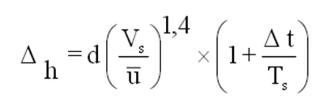

In [49]:
# Função de sobrelevação da pluma de Davidson-Bryant
def deltaHdavidsonBryant(d, vs, u, Ts, Tamb):
    deltaH = (d * (vs / u) ** 1.4) * (1 + (Ts - Tamb) / Ts)
    return deltaH


Método Holland
A sobrelevação da pluma pelo método Holland é calculada como:

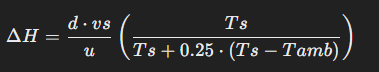

In [50]:
# Função de sobrelevação da pluma de Holland
def deltaHholland(d, vs, u, Ts, Tamb):
    deltaH = (d * vs / u) * (Ts / (Ts + 0.25 * (Ts - Tamb)))
    return deltaH


Método de Briggs

A sobrelevação da pluma pelo método Briggs leva em consideração diferentes fórmulas dependendo do regime de estabilidade.

In [51]:
import math

#Função plume_rise_briggs Melhorada:
#Cálculo do Empuxo Térmico (F): Considera a diferença de temperatura entre os gases de exaustão e o ambiente.
#Ajuste para Condições de Estabilidade: Diferencia entre plumas em condições estáveis e instáveis/neutras.

# Função para estimar a sobrelevação da pluma pelo método de Briggs
def plume_rise_briggs(Q, u, D, H, stability_class, Ts, Tamb, vs):
    """
    Estima a sobrelevação da pluma usando o método de Briggs.
    
    Parâmetros:
    Q (float): Taxa de emissão de calor (kW)
    u (float): Velocidade do vento (m/s)
    D (float): Diâmetro da chaminé (m)
    H (float): Altura da chaminé (m)
    stability_class (str): Classe de estabilidade de Pasquil
    Ts (float): Temperatura dos gases de exaustão (K)
    Tamb (float): Temperatura ambiente (K)
    vs (float): Velocidade de saída dos gases (m/s)
    
    Retorno:
    float: Sobrelevação da pluma (m)
    """
    g = 9.81  # Aceleração da gravidade (m/s^2)
    dT = Ts - Tamb  # Diferença de temperatura entre os gases de exaustão e o ambiente

    if stability_class in ['A', 'B', 'C']:
        # Plumas para condições instáveis ou neutras
        if vs / u < 1.5:
            # Dominada pelo empuxo térmico
            F = (g * D**2 * vs * dT) / (4 * Ts)
            delta_h = 1.6 * (F / (u**3))**0.333
        else:
            # Dominada pelo impulso
            delta_h = 3 * (vs * D / u)
    else:
        # Plumas para condições estáveis
        if vs / u < 1.5:
            # Dominada pelo empuxo térmico
            F = (g * D**2 * vs * dT) / (4 * Ts)
            delta_h = 2.6 * (F / (u**3))**0.333
        else:
            # Dominada pelo impulso
            delta_h = 1.5 * (vs * D / u)
    
    return delta_h

# Função para calcular o efeito Tip-Downwash
def efeitoTipDownwash(H):
    """
    Calcula o efeito de Tip-Downwash, uma redução na altura efetiva da pluma.
    
    Parâmetros:
    H (float): Altura da chaminé (m)
    
    Retorno:
    float: Redução na altura devido ao efeito Tip-Downwash (m)
    """
    deltaH_downwash = 0.1 * H  # 10% da altura da chaminé
    return deltaH_downwash

Passo 4: Implementar a função do modelo gaussiano

In [52]:
import numpy as np
import math

# Função do modelo Gaussiano
def gaussian_model(Q, u, H, x, y, z, stability_class):
    '''
    Modelo Gaussiano para estimativa da concentração de poluentes.
    
    Parâmetros:
    Q (float): Taxa de emissão (g/s)
    u (float): Velocidade do vento (m/s)
    H (float): Altura efetiva da chaminé (m)
    x (float): Distância na direção do vento (m)
    y (float): Distância lateral (m)
    z (float): Altura acima do solo (m)
    stability_class (str): Classe de estabilidade de Pasquil
    
    Retorno:
    float: Concentração de poluentes (g/m^3)
    '''
    sigma_y, sigma_z = sigma_yz(x, stability_class)
    
    exp_y = math.exp(-0.5 * (y / sigma_y)**2)
    exp_z1 = math.exp(-0.5 * ((z - H) / sigma_z)**2)
    exp_z2 = math.exp(-0.5 * ((z + H) / sigma_z)**2)
    
    C = (Q / (2 * math.pi * u * sigma_y * sigma_z)) * exp_y * (exp_z1 + exp_z2)
    
    return C

Cálculo da Sobrelevação da Pluma pelo método de Brigss e Concentração pelo Modelo Gaussiano:

C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\1775653101.py:43: RuntimeWarning: divide by zero encountered in divide
  exp_y = np.exp(-0.5 * (y / sigma_y)**2)
C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\1775653101.py:44: RuntimeWarning: divide by zero encountered in divide
  exp_z1 = np.exp(-0.5 * ((z - H) / sigma_z)**2)
C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\1775653101.py:45: RuntimeWarning: divide by zero encountered in divide
  exp_z2 = np.exp(-0.5 * ((z + H) / sigma_z)**2)
C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\1775653101.py:46: RuntimeWarning: divide by zero encountered in divide
  C = (Q / (2 * np.pi * u * sigma_y * sigma_z)) * exp_y * (exp_z1 + exp_z2)
C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\1775653101.py:46: RuntimeWarning: invalid value encountered in multiply
  C = (Q / (2 * np.pi * u * sigma_y * sigma_z)) * exp_y * (exp_z1 + exp_z2)


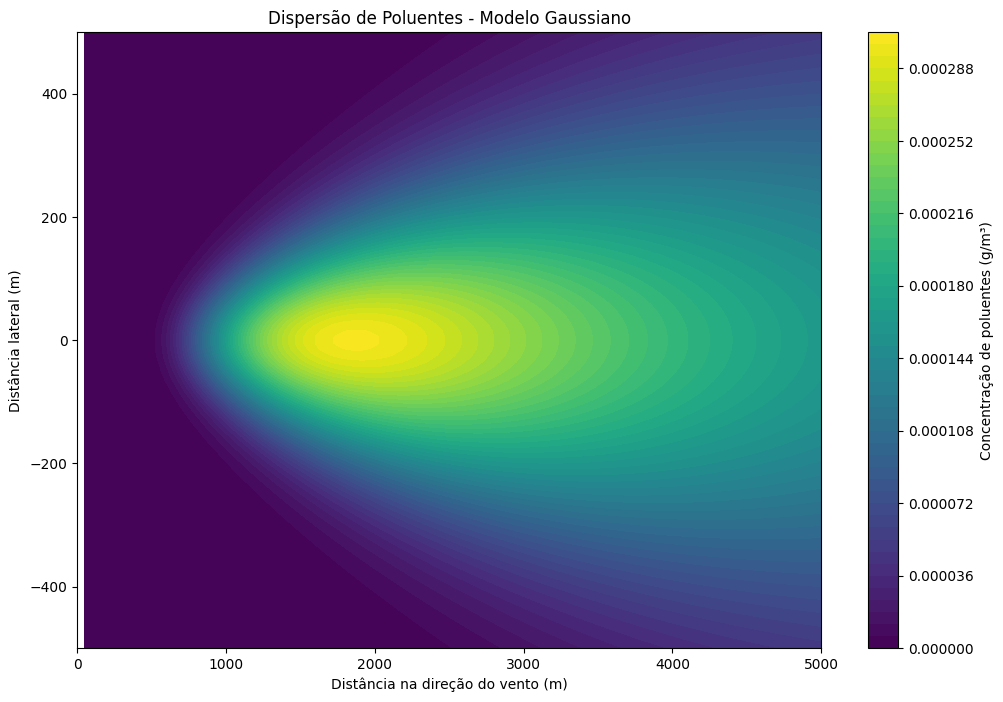

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Função para calcular sigma_y e sigma_z
def sigma_yz(x, stability_class):
    if stability_class == 'A':
        sigma_y = 0.22 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.20 * x
    elif stability_class == 'B':
        sigma_y = 0.16 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.12 * x
    elif stability_class == 'C':
        sigma_y = 0.11 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.08 * x * (1 + 0.0002 * x)**(-0.5)
    elif stability_class == 'D':
        sigma_y = 0.08 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.06 * x * (1 + 0.0015 * x)**(-0.5)
    elif stability_class == 'E':
        sigma_y = 0.06 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.03 * x * (1 + 0.0003 * x)**(-0.5)
    elif stability_class == 'F':
        sigma_y = 0.04 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.016 * x * (1 + 0.0003 * x)**(-0.5)
    else:
        sigma_y = 0.08 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.06 * x * (1 + 0.0015 * x)**(-0.5)
    return sigma_y, sigma_z

# Função para calcular a sobrelevação da pluma usando o método de Briggs
def plume_rise_briggs(Q, u, D, stability_class):
    if stability_class in ['A', 'B', 'C']:
        F = 0.020
    else:
        F = 0.035
    w = (4 * Q / (math.pi * D**2))**(1/3)
    delta_h = F * (Q / (u * D))**(1/3)
    return delta_h

# Função para calcular a concentração de poluentes usando o modelo gaussiano
def gaussian_model(Q, u, H, x, y, z, stability_class):
    sigma_y, sigma_z = sigma_yz(x, stability_class)
    exp_y = np.exp(-0.5 * (y / sigma_y)**2)
    exp_z1 = np.exp(-0.5 * ((z - H) / sigma_z)**2)
    exp_z2 = np.exp(-0.5 * ((z + H) / sigma_z)**2)
    C = (Q / (2 * np.pi * u * sigma_y * sigma_z)) * exp_y * (exp_z1 + exp_z2)
    return C

# Função para calcular o efeito Tip-Downwash
def efeitoTipDownwash(H):
    deltaH_downwash = 0.1 * H  # 10% da altura da chaminé
    return deltaH_downwash

# Parâmetros
Q = 127.83  # Taxa de emissão em g/s do empreendimento Saluma Engenharia
u = 5  # Velocidade do vento em m/s
D = 1  # Diâmetro da chaminé em m
H = 100  # Altura da chaminé em m
x_values = np.linspace(0, 5000, 100)  # Distâncias na direção do vento em m
y_values = np.linspace(-500, 500, 100)  # Distâncias laterais em m
z = 1.5  # Altura de interesse acima do solo em m
insolation = 'moderada'
stability_class = pasquill_stability_class(u, insolation)

# Calcular a sobrelevação da pluma usando Briggs
deltaH_briggs = plume_rise_briggs(Q, u, D, stability_class)
hef = H + deltaH_briggs - efeitoTipDownwash(H)

# Criar a grade de pontos
xx, yy = np.meshgrid(x_values, y_values)

# Calcular a concentração de poluentes em cada ponto da grade
concentrations = gaussian_model(Q, u, hef, xx, yy, z, stability_class)

# Visualizar as plumas
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, concentrations, levels=50, cmap='viridis')
plt.colorbar(label='Concentração de poluentes (g/m³)')
plt.xlabel('Distância na direção do vento (m)')
plt.ylabel('Distância lateral (m)')
plt.title('Dispersão de Poluentes - Modelo Gaussiano')
plt.show()

#pasquill_stability_class: Determina a classe de estabilidade de Pasquill com base na velocidade do vento e insolação.
#sigma_yz: Calcula os coeficientes de dispersão sigma_y e sigma_z baseados na classe de estabilidade e distância.
#plume_rise_briggs: Calcula a sobrelevação da pluma usando o método de Briggs.
#gaussian_model: Calcula a concentração de poluentes usando o modelo gaussiano.
#efeitoTipDownwash: Calcula a redução na altura efetiva da pluma devido ao efeito Tip-Downwash.

Passo 5: Simulações e análises

C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\782085744.py:75: RuntimeWarning: invalid value encountered in scalar divide
  exp_y = math.exp(-0.5 * (y / sigma_y)**2)
C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\782085744.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  exp_z1 = math.exp(-0.5 * ((z - H) / sigma_z)**2)
C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\782085744.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  exp_z2 = math.exp(-0.5 * ((z + H) / sigma_z)**2)
C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\782085744.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  C = (Q / (2 * math.pi * u * sigma_y * sigma_z)) * exp_y * (exp_z1 + exp_z2)


Alturas mínimas da chaminé para não violar os padrões da Resolução CONAMA 491:


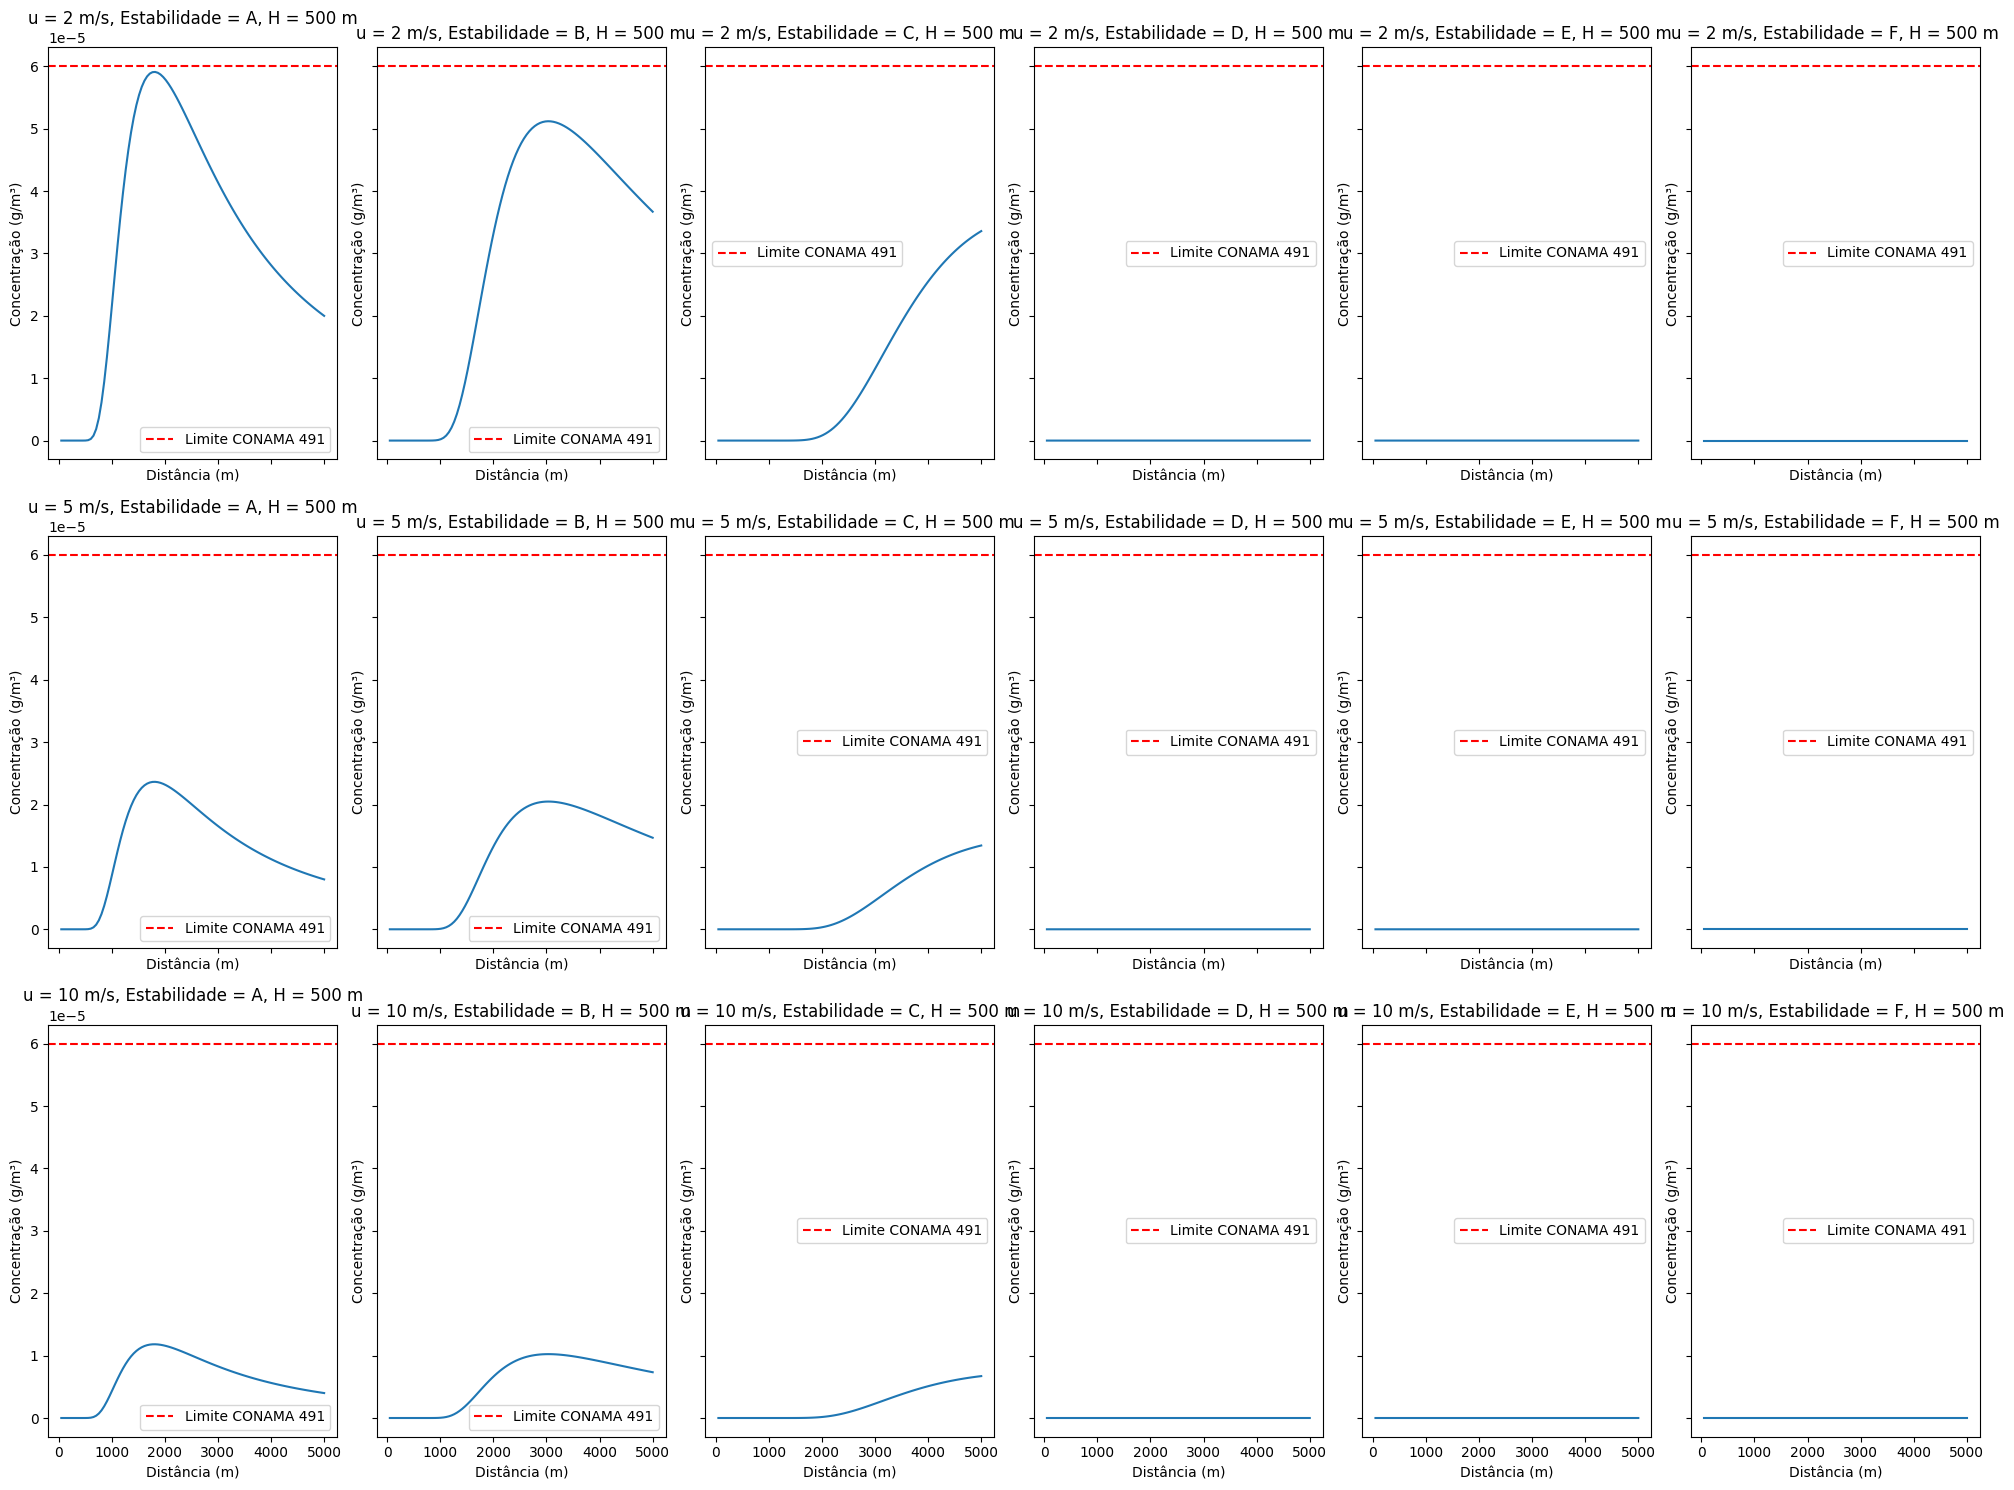

C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\782085744.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  exp_y = math.exp(-0.5 * (y / sigma_y)**2)
C:\Users\Win10\AppData\Local\Temp\ipykernel_17904\782085744.py:78: RuntimeWarning: invalid value encountered in scalar multiply
  C = (Q / (2 * math.pi * u * sigma_y * sigma_z)) * exp_y * (exp_z1 + exp_z2)


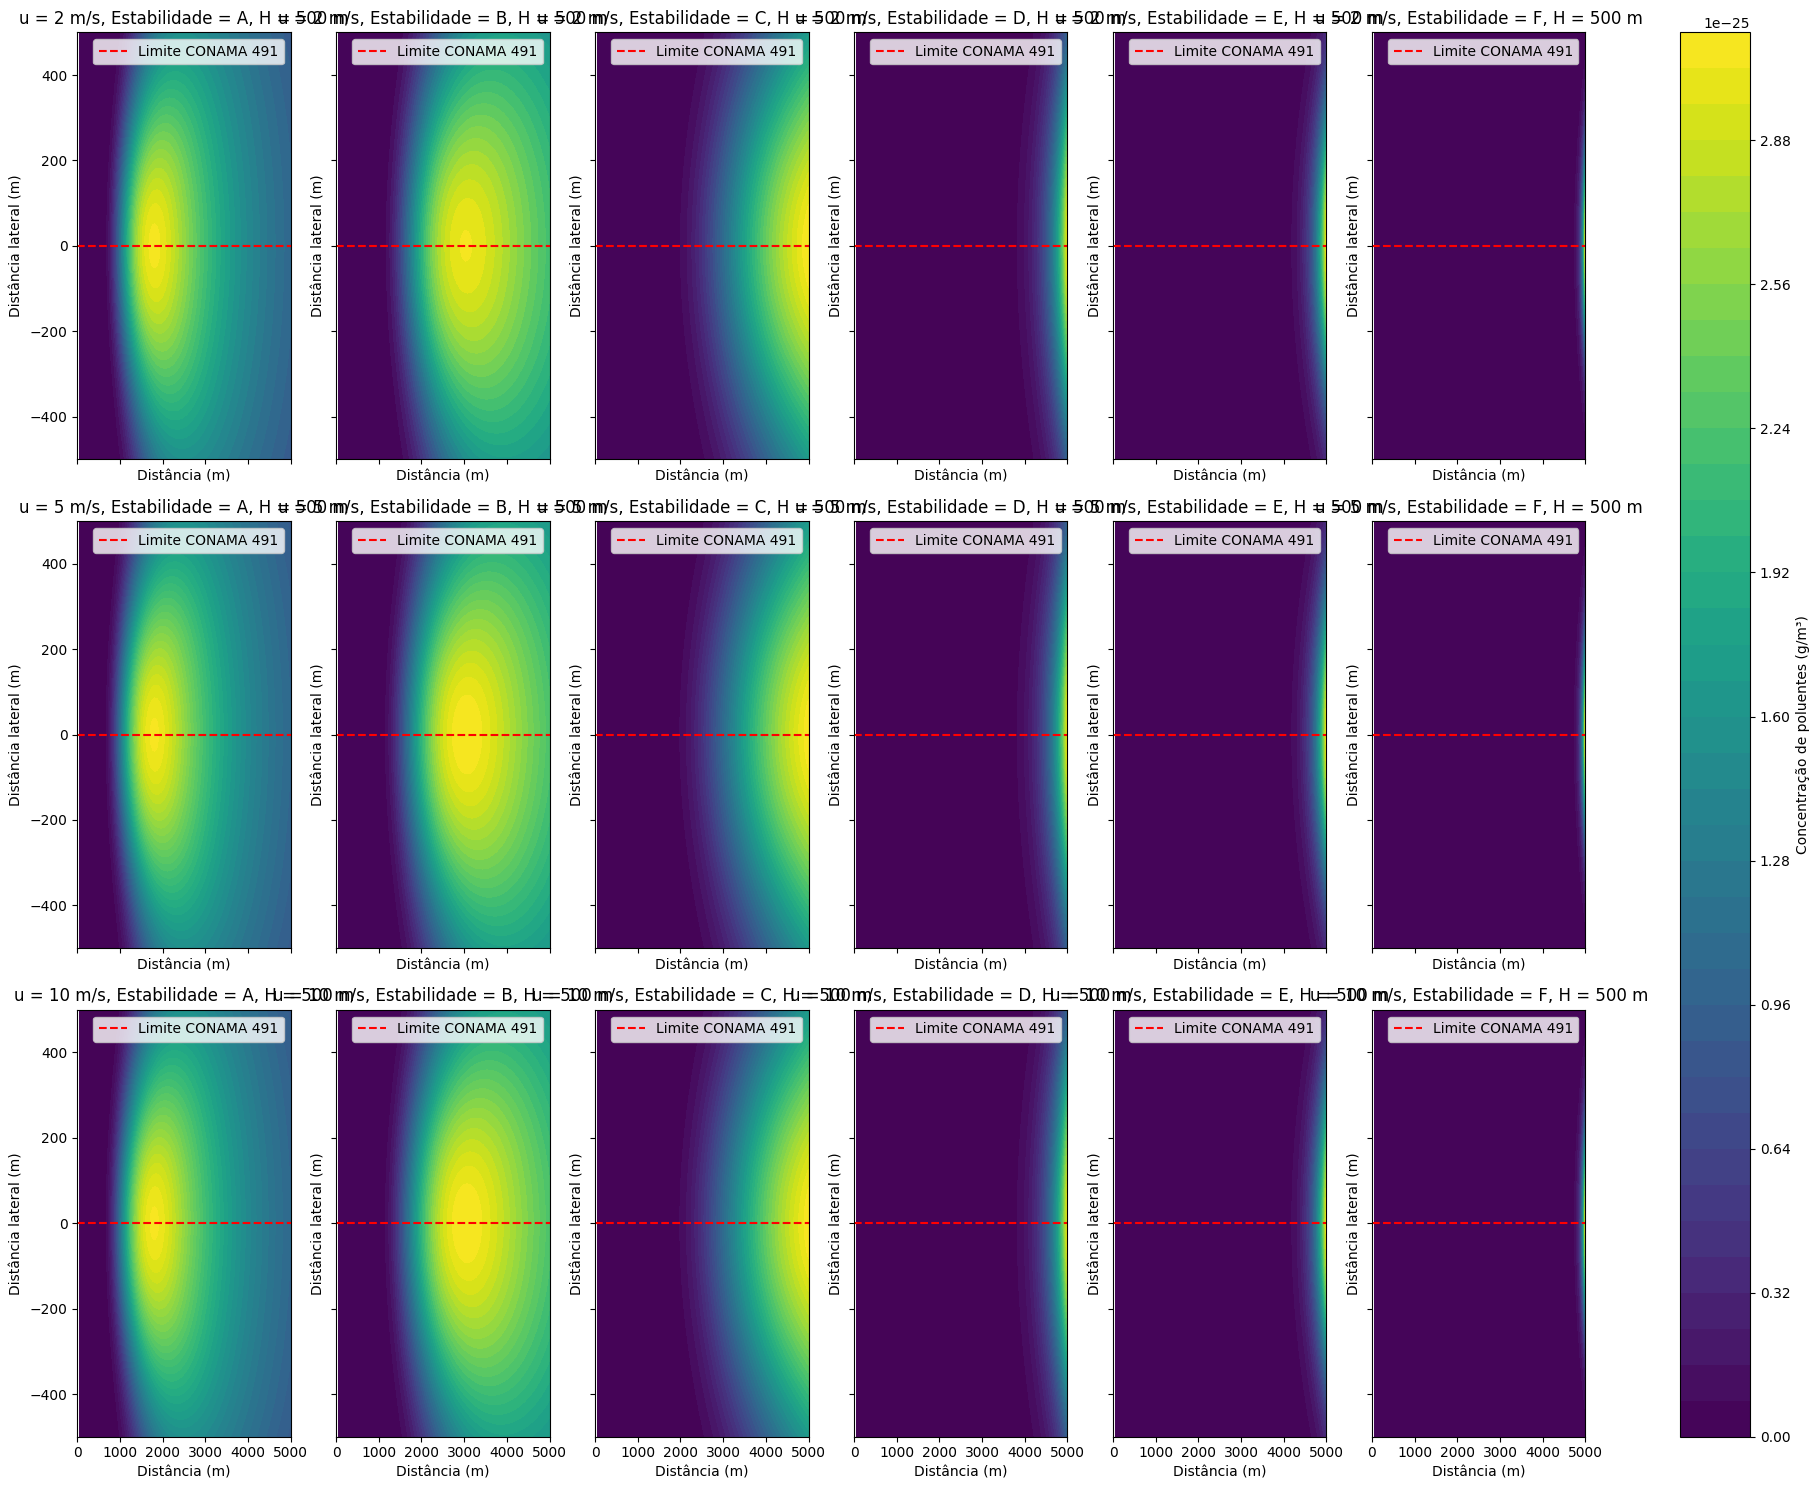

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Funções auxiliares
def pasquill_stability_class(wind_speed, insolation):
    if insolation == 'alta':
        if wind_speed < 2:
            return 'A'
        elif wind_speed < 3:
            return 'B'
        else:
            return 'C'
    elif insolation == 'moderada':
        if wind_speed < 2:
            return 'B'
        elif wind_speed < 5:
            return 'C'
        else:
            return 'D'
    elif insolation == 'baixa':
        if wind_speed < 2:
            return 'C'
        elif wind_speed < 5:
            return 'D'
        else:
            return 'D'
    elif insolation == 'nublada':
        return 'D'
    elif insolation == 'noturna':
        if wind_speed < 2:
            return 'F'
        elif wind_speed < 5:
            return 'E'
        else:
            return 'D'
    else:
        return 'D'

def sigma_yz(x, stability_class):
    if stability_class == 'A':
        sigma_y = 0.22 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.20 * x
    elif stability_class == 'B':
        sigma_y = 0.16 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.12 * x
    elif stability_class == 'C':
        sigma_y = 0.11 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.08 * x * (1 + 0.0002 * x)**(-0.5)
    elif stability_class == 'D':
        sigma_y = 0.08 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.06 * x * (1 + 0.0015 * x)**(-0.5)
    elif stability_class == 'E':
        sigma_y = 0.06 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.03 * x * (1 + 0.0003 * x)**(-0.5)
    elif stability_class == 'F':
        sigma_y = 0.04 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.016 * x * (1 + 0.0003 * x)**(-0.5)
    else:
        sigma_y = 0.08 * x * (1 + 0.0001 * x)**(-0.5)
        sigma_z = 0.06 * x * (1 + 0.0015 * x)**(-0.5)
    return sigma_y, sigma_z

def plume_rise_briggs(Q, u, D, H, stability_class):
    if stability_class in ['A', 'B', 'C']:
        F = 0.020
    else:
        F = 0.035
    w = (4 * Q / (math.pi * D**2))**(1/3)
    delta_h = F * (Q / (u * D))**(1/3)
    return delta_h

def gaussian_model(Q, u, H, x, y, z, stability_class):
    sigma_y, sigma_z = sigma_yz(x, stability_class)
    exp_y = math.exp(-0.5 * (y / sigma_y)**2)
    exp_z1 = math.exp(-0.5 * ((z - H) / sigma_z)**2)
    exp_z2 = math.exp(-0.5 * ((z + H) / sigma_z)**2)
    C = (Q / (2 * math.pi * u * sigma_y * sigma_z)) * exp_y * (exp_z1 + exp_z2)
    return C

def run_simulation(Q, u_values, H_values, x_values, stability_classes, conama_limit):
    results = []
    for u in u_values:
        for stability_class in stability_classes:
            for H in H_values:
                concentrations = []
                for x in x_values:
                    y = 0
                    z = 0
                    C = gaussian_model(Q, u, H, x, y, z, stability_class)
                    concentrations.append(C)
                max_concentration = max(concentrations)
                if max_concentration <= conama_limit:
                    results.append((u, stability_class, H, max_concentration))
    return results

Q = 127.83  # Taxa de emissão em g/s
u_values = [2, 5, 10]  # Velocidades do vento em m/s - Em SC teve velocidades com médias de vento acima de 3,4 m/s nas épocas com mais ventos.
H_values = np.arange(100, 511, 20)  # Alturas da chaminé de 100 a 500 metros, com passo de 30 metros
x_values = np.linspace(0, 5000, 100)  # Distâncias na direção do vento em metros
stability_classes = ['A', 'B', 'C', 'D', 'E', 'F']  # Classes de estabilidade
conama_limit = 60 / 1e6  # Limite diário da Resolução CONAMA 491 em g/m³ (60 µg/m³)

results = run_simulation(Q, u_values, H_values, x_values, stability_classes, conama_limit)

min_heights = {}
for u in u_values:
    for stability_class in stability_classes:
        valid_heights = [result[2] for result in results if result[0] == u and result[1] == stability_class]
        if valid_heights:
            min_height = min(valid_heights)
            min_heights[(u, stability_class)] = min_height

print("Alturas mínimas da chaminé para não violar os padrões da Resolução CONAMA 491:")
for (u, stability_class), min_height in min_heights.items():
    print(f"Velocidade do vento: {u} m/s, Classe de estabilidade: {stability_class}, Altura mínima: {min_height} m")

fig, ax = plt.subplots(len(u_values), len(stability_classes), figsize=(20, 15), sharex=True, sharey=True)

for i, u in enumerate(u_values):
    for j, stability_class in enumerate(stability_classes):
        concentrations = []
        for x in x_values:
            y = 0
            z = 0
            H = min_heights.get((u, stability_class), H_values[-1])  # Usar a altura mínima ou a última altura se não encontrada
            C = gaussian_model(Q, u, H, x, y, z, stability_class)
            concentrations.append(C)
        ax[i, j].plot(x_values, concentrations)
        ax[i, j].axhline(conama_limit, color='r', linestyle='--', label='Limite CONAMA 491')
        ax[i, j].set_title(f'u = {u} m/s, Estabilidade = {stability_class}, H = {H} m')
        ax[i, j].set_xlabel('Distância (m)')
        ax[i, j].set_ylabel('Concentração (g/m³)')
        ax[i, j].legend()

plt.tight_layout()
plt.show()

# Plotando as plumas de poluição
fig, ax = plt.subplots(len(u_values), len(stability_classes), figsize=(20, 15), sharex=True, sharey=True)

for i, u in enumerate(u_values):
    for j, stability_class in enumerate(stability_classes):
        H = min_heights.get((u, stability_class), H_values[-1])  # Usar a altura mínima ou a última altura se não encontrada
        concentrations = []
        for x in x_values:
            row = []
            for y in y_values:
                z = 0
                C = gaussian_model(Q, u, H, x, y, z, stability_class)
                row.append(C)
            concentrations.append(row)
        concentrations = np.array(concentrations)
        xx, yy = np.meshgrid(x_values, y_values)
        contour = ax[i, j].contourf(xx, yy, concentrations.T, levels=50, cmap='viridis')
        ax[i, j].axhline(conama_limit, color='r', linestyle='--', label='Limite CONAMA 491')
        ax[i, j].set_title(f'u = {u} m/s, Estabilidade = {stability_class}, H = {H} m')
        ax[i, j].set_xlabel('Distância (m)')
        ax[i, j].set_ylabel('Distância lateral (m)')
        ax[i, j].legend()

plt.tight_layout()
fig.colorbar(contour, ax=ax.ravel().tolist(), orientation='vertical', label='Concentração de poluentes (g/m³)')
plt.show()

Ao gerar os gráficos da concentração em função da distância, considerando a variação da velocidade do vento e a altura da chaminé para diversos cenários, observamos que, para que as concentrações não excedam os limites estabelecidos pela Resolução CONAMA 491, a altura da chaminé deve ser de 310 metros nas condições mais críticas, que ocorrem quando a velocidade do vento é mais baixa. 

No entanto, uma chaminé com essa altura não é viável. Nesses casos, é necessário buscar tecnologias para reduzir a concentração emitida ou realizar um estudo para avaliar se o impacto está causando algum prejuízo na região em volta.